# Athens week 2025: Geostatistics Practicals


# I - Kriging

The aim of this practical session is to manipulate the kriging utilities from the *gstlearn* package.

## I.1 - Load Packages and data

In [1]:
import numpy as np
import random as rd
import pandas as pd
import matplotlib.pyplot as plt
import gstlearn as gl
import gstlearn.plot as gp
import minigst as mg

## Figure sizes
plt.rcParams["figure.figsize"] = [8, 6]

We start by loading the data.

In [2]:
## Dataset
jura_all, grid, _ = mg.data("Jura")
jura_all

,Xloc,Yloc,Landuse,Rock,Cd,Co,Cr,Cu,Ni,Pb,Zn
0,2.386,3.077,3,3,1.740,9.32,38.32,25.72,21.32,77.36,92.56
1,2.544,1.972,2,2,1.335,10.00,40.20,24.76,29.72,77.88,73.56
2,2.807,3.347,2,3,1.610,10.60,47.00,8.88,21.40,30.80,64.80
3,4.308,1.933,3,2,2.150,11.92,43.52,22.70,29.72,56.40,90.00
4,4.383,1.081,3,5,1.565,16.32,38.52,34.32,26.20,66.40,88.40
...,...,...,...,...,...,...,...,...,...,...,...
254,4.283,3.278,3,2,0.844,13.88,37.12,21.04,26.48,34.68,90.00
255,3.530,4.999,1,1,0.490,7.44,34.52,4.64,16.76,31.64,56.80
256,4.070,4.157,3,3,1.916,14.36,47.60,45.60,28.44,50.00,90.80
257,4.610,3.315,1,2,1.384,12.68,30.76,7.48,20.72,48.00,46.80


Separate the data set in two sets : the training set and the validation set.
For the project and the Kaggle competition, you should use the full data set for 
the training.
You will submit your prediction on Kaggle for a set of locations on which you will 
only know the locations and the factors of Land Use and Rock at these locations.

In [3]:
## Separation Training/Validation data
ntot = jura_all.shape[0]
ntrain = 200  ## Number of training samples
nval = ntot - ntrain
rd.seed(1)
indtrain = rd.sample(range(ntot), ntrain)  ## Indices of training samples
indval = np.setdiff1d(np.arange(ntot), indtrain)  ## Indices of validation samples

## Training dataset
jura = jura_all.loc[indtrain, :]

## Location of the validation points
val_loc = jura_all.loc[indval, ["Xloc", "Yloc", "Landuse", "Rock"]]

## Response variable (Cobalt concentration) at the validation locations
val = jura_all.loc[indval, ["Co"]]

Function to plot a grid

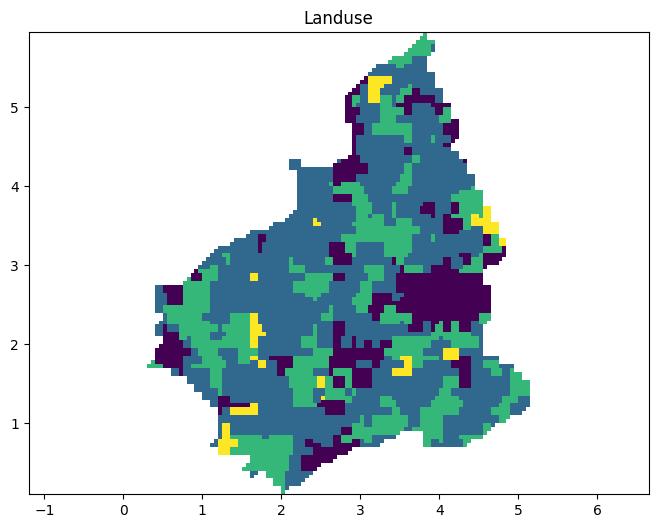

In [4]:
def plot_grid(grid, vname, title=None, colorbar=False):
    dbgrid = mg.df_to_dbgrid(grid, ["Xloc", "Yloc"])
    im = gp.plot(dbgrid, vname)
    if colorbar:
        plt.colorbar(im)
    if title is not None:
        plt.title(title)
    ax = plt.axis("equal")


# Example
plot_grid(grid, "Landuse")

## I.2 - Simple kriging : Do it yourself

In this section, we compute manually a simple kriging prediction of the Cobalt concentrations on a target grid.

We first load the coordinates of a target grid on which we will predict the Cobalt concentrations.

We start by fitting an exponential covariance model to the data using the same approach as in the previous practical session.

In [5]:
## Convert Pandas dataframe containing the training data into gstlearn Db
db_jura = mg.df_to_db(jura, coord_names=["Xloc", "Yloc"])

## Create experimental variogram
varioexp = mg.vario_exp(db_jura, vname="Co", nlag=30, dlag=0.1, toldis=0.5)

## Fit experimental variogram with an exponential covariance
types = ["EXPONENTIAL"]
fitmod = mg.model_fit(varioexp, struct=types)
fitmod.display()


Model characteristics
Space dimension              = 2
Number of variable(s)        = 1
Number of basic structure(s) = 1
Number of drift function(s)  = 0
Number of drift equation(s)  = 0

Covariance Part
---------------
Exponential
- Sill         =     13.444
- Range        =      1.260
- Theo. Range  =      0.421
Total Sill     =     13.444
Known Mean(s)     0.000


We then extract the sill and scale (also called "Theroretical range") parameters from the fitted model.

In [6]:
## Extract
sill_fit = fitmod.getCovAniso(0).getSill(0, 0)
scale_fit = fitmod.getCovAniso(0).getScale(0)

## Print
print("sill =", sill_fit)
print("scale =", scale_fit)

sill = 13.443721554076863
scale = 0.4205078471051604


**Create a function that evaluates an exponential covariance model at a given lag h, with the sill and scale parameters fitted above.**

In [7]:
## Inputs:
##### h : Lag value (or vector)
## Output
##### Value of the exponential covariance model (with scale and sill defined above) at lag h : C(h)= sill * exp(-h/scale)


def Cexp(h):
    return sill_fit * np.exp(-h / scale_fit)

We will now implement the simple kriging prediction and the kriging error standard deviation (on a unique neighborhood) to estimate the concentration of Cobalt on the points defined in the target grid `grid`, using the data in the data frame `jura`.


**Compute the mean of the Cobalt observations (which we will use as the simple kriging mean).**

In [8]:
mean_Co = jura["Co"].mean()
mean_Co

np.float64(9.19706)

**Build the matrix of covariance values between the pairs of data points  (Size : Number of data points x Number of data points). (Hint: Use the function `np.subtract.outer` to efficiently compute distance matrices)**

In [9]:
## Compute matrix of distances between the pairs of points
dist_data = (
    np.subtract.outer(jura["Xloc"].to_numpy(), jura["Xloc"].to_numpy()) ** 2
    + np.subtract.outer(jura["Yloc"].to_numpy(), jura["Yloc"].to_numpy()) ** 2
) ** 0.5

## Compute matrix of covariances between the pairs of points using dist_dat and Cexp
cov_data = Cexp(dist_data)

**Compute the matrix of covariance values between the target points and the data points (Size : Number of target points x Number of data points)**

In [10]:
## Compute matrix of distances between the data points and the target points
dist_tar = (
    np.subtract.outer(grid["Xloc"].to_numpy(), jura["Xloc"].to_numpy()) ** 2
    + np.subtract.outer(grid["Yloc"].to_numpy(), jura["Yloc"].to_numpy()) ** 2
) ** 0.5

## Compute matrix of covariances between the pairs of points
cov_tar = Cexp(dist_tar)

**Extract the values of Cobalt concentrations into a vector**

In [11]:
values_Co = jura["Co"].to_numpy()

**Compute the simple kriging predictor (Hint: Use `np.linalg.solve` to solve a linear system and `np.matmul` for matrix products)**

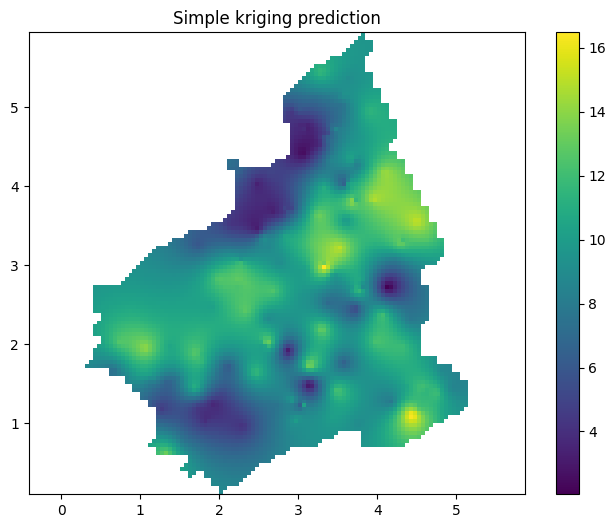

In [12]:
## Compute the kriging predictor
SK_Co_pred_grid = mean_Co + np.matmul(
    cov_tar, np.linalg.solve(cov_data, values_Co - mean_Co)
)
grid["SK_Co_pred"] = SK_Co_pred_grid
plot_grid(grid, "SK_Co_pred", "Simple kriging prediction", colorbar=True)

**Compute the simple kriging variance (Hint: Use the method `transpose()` to transpose a matrix and `np.diag` to extract the diagonal elements of a matrix)**

In [13]:
SK_Co_var_grid = np.diag(
    sill_fit - np.matmul(cov_tar, np.linalg.solve(cov_data, cov_tar.transpose()))
)
grid["SK_stdev"] = np.sqrt(SK_Co_var_grid)

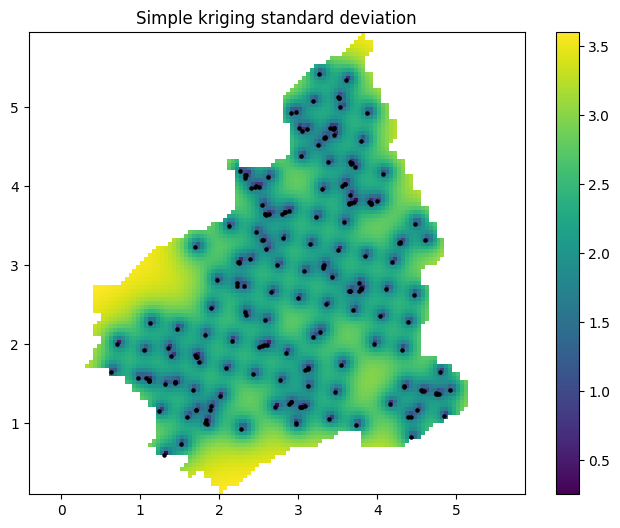

In [14]:
## Plot results
plot_grid(grid, "SK_stdev", "Simple kriging standard deviation", colorbar=True)
plt.scatter(jura.Xloc, jura.Yloc, s=5, c="black")

**Compute the simple kriging prediction and variance at the validation locations (in the dataframe `val_loc`)**

In [15]:
## Compute matrix of distances between the data points and the validation points
dist_val = (
    np.subtract.outer(val_loc["Xloc"].to_numpy(), jura["Xloc"].to_numpy()) ** 2
    + np.subtract.outer(val_loc["Yloc"].to_numpy(), jura["Yloc"].to_numpy()) ** 2
) ** 0.5

## Compute matrix of covariances
cov_val = Cexp(dist_val)

## Simple kriging prediction
SK_Co_pred_val = mean_Co + np.matmul(
    cov_val, np.linalg.solve(cov_data, values_Co - mean_Co)
)

## Simple kriging variance
SK_Co_var_val = np.diag(
    sill_fit - np.matmul(cov_val, np.linalg.solve(cov_data, cov_val.transpose()))
)

**Compute the resulting RMSE and MAPE.**

In [16]:
## RMSE
print("RMSE=", np.mean((SK_Co_pred_val - val["Co"]) ** 2) ** 0.5)

## MAPE
print("MAPE=", np.mean(abs((SK_Co_pred_val - val["Co"]) / val["Co"])))

RMSE= 2.3503606655718263
MAPE= 0.2355298762859361


## I.3 - Kriging using gstlearn

We know use gstlearn to perform kriging.

First, we create a gstlearn database containing the data points, and assign the appropriate locators to the variables.

In [17]:
## Create Db containing the training data
db_jura = mg.df_to_db(jura, ["Xloc", "Yloc"])

## Display content
db_jura.display()


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 11
Total number of samples      = 200

Variables
---------
Column = 0 - Name = Xloc - Locator = x1
Column = 1 - Name = Yloc - Locator = x2
Column = 2 - Name = Landuse - Locator = NA
Column = 3 - Name = Rock - Locator = NA
Column = 4 - Name = Cd - Locator = NA
Column = 5 - Name = Co - Locator = NA
Column = 6 - Name = Cr - Locator = NA
Column = 7 - Name = Cu - Locator = NA
Column = 8 - Name = Ni - Locator = NA
Column = 9 - Name = Pb - Locator = NA
Column = 10 - Name = Zn - Locator = NA


We also create a gstlearn *Grid Database* containing the target grid for the prediction.

In [18]:
## Create DbGrid that covers the Db containing the data
db_grid = mg.df_to_dbgrid(grid, ["Xloc", "Yloc"])
db_grid.display()


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 7
Total number of samples      = 11349

Grid characteristics:
---------------------
Origin :      0.300     0.100
Mesh   :      0.050     0.050
Number :         97       117

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = Xloc - Locator = x1
Column = 2 - Name = Yloc - Locator = x2
Column = 3 - Name = Landuse - Locator = NA
Column = 4 - Name = Rock - Locator = NA
Column = 5 - Name = SK_Co_pred - Locator = NA
Column = 6 - Name = SK_stdev - Locator = z1


Finally, we create a Db containing the validation locations and the value of Cobalt concentrations at those locations.

In [19]:
## Create Db
db_val = mg.df_to_db(val_loc, ["Xloc", "Yloc"])
db_val.display()


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 4
Total number of samples      = 59

Variables
---------
Column = 0 - Name = Xloc - Locator = x1
Column = 1 - Name = Yloc - Locator = x2
Column = 2 - Name = Landuse - Locator = NA
Column = 3 - Name = Rock - Locator = NA


### 1 - Simple kriging

To perform simple kriging, we use the `minigst` function called `minikriging`. We specify at least:

- the Db object containing the data points (argument `dbin` )
- the Db object containing the target points, i.e. the points where the kriging predictor will be computed (argument `dbout` )
- the name of variable, in `dbin`, we want to predict for kriging 
- the Model object containing the model used to define the kriging predictor (argument `model` )

To perform simple kriging, we set `type=simple` and set the argment `mean` to the value of the mean we want to use. Otherwise, ordinary kriging is performed.

The `minikriging` function  adds new variables to the Db entered in the prediction Db given in the `dbout` argument, whose name will start with a prefix specified with the `prefix` argument (Default = "K"): 

- A variable named `prefix.vname.estim` containing the kriging prediction
- A variable named `prefix.vname.stdev` containing the kriging standard-deviation

More info on the `minikriging` function are available on its help page.

Hence, to perform a simple kriging prediction we can follow these steps:

**Compute the simple kriging prediction and standard-deviation at the validation locations (instead of the target grid), and compute the resulting RMSE and MAPE. (Hint: Use the prefix "SK" to store the results)**

In [20]:
## Compute kriging
mg.minikriging(
    db_jura, db_val, model=fitmod, vname="Co", type="simple", mean=mean_Co, prefix="SK"
)
db_val.display()


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 6
Total number of samples      = 59

Variables
---------
Column = 0 - Name = Xloc - Locator = x1
Column = 1 - Name = Yloc - Locator = x2
Column = 2 - Name = Landuse - Locator = NA
Column = 3 - Name = Rock - Locator = NA
Column = 4 - Name = SK.Co.estim - Locator = z1
Column = 5 - Name = SK.Co.stdev - Locator = NA


No variable name corresponding to your criterion


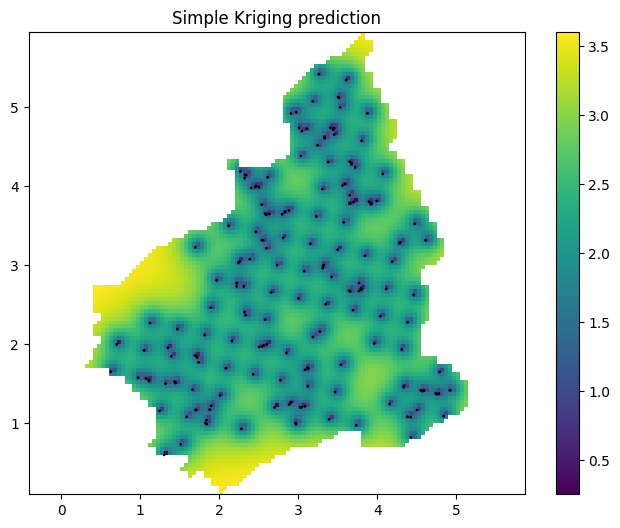

No variable name corresponding to your criterion


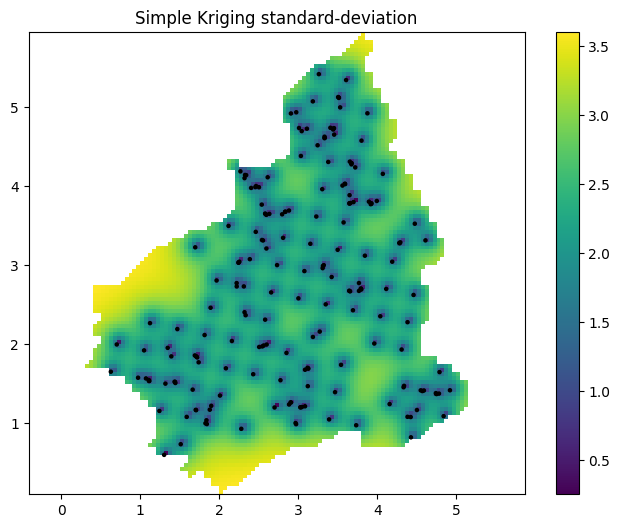

In [21]:
## Plot prediction
im = gp.plot(db_grid, "SK.Co.estim")
gp.plot(db_jura, c="black", s=1)
plt.title("Simple Kriging prediction")
plt.axis("equal")
plt.colorbar(im)
plt.show()

## Plot kriging standard-deviation
im = gp.plot(db_grid, "SK.Co.stdev")
gp.plot(db_jura, c="black", s=5)
plt.title("Simple Kriging standard-deviation")
plt.axis("equal")
plt.colorbar(im)
plt.show()

In [22]:
## Compute RMSE
rmse_SK = np.mean((val["Co"] - db_val["SK*estim"]) ** 2) ** 0.5
print("RMSE=", rmse_SK)

## Compute MAPE
mape_SK = np.mean(abs((val["Co"] - db_val["SK*estim"]) / val["Co"]))
print("MAPE=", mape_SK)

RMSE= 2.3503606655718245
MAPE= 0.2355298762859382


### 2 - Ordinary kriging

With `minigst`, ordinary kriging  also performed with the `minikriging` function. The only difference with performing simple kriging is that now, the argument `type` can be left unspecified (or set to `type="ordinary"`). As for the argument `mean`, it is simply ignored.

**Computing the ordinary kriging prediction and standard-deviation at the validation locations (instead of the target grid), and compute the resulting RMSE and MAPE.(Hint: Use the prefix "OK" to store the results)**

In [23]:
## Remove variables starting with a given prefix (-> Results from previous runs)
mg.del_var_from_db(db_val, "OK*")

## Compute ordinary kriging
mg.minikriging(
    db_jura,
    db_val,
    model=fitmod,
    vname="Co",
    type="ordinary",
    mean=mean_Co,
    prefix="OK",
)
db_val.display()


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 8
Total number of samples      = 59

Variables
---------
Column = 0 - Name = Xloc - Locator = x1
Column = 1 - Name = Yloc - Locator = x2
Column = 2 - Name = Landuse - Locator = NA
Column = 3 - Name = Rock - Locator = NA
Column = 4 - Name = SK.Co.estim - Locator = NA
Column = 5 - Name = SK.Co.stdev - Locator = NA
Column = 6 - Name = OK.Co.estim - Locator = z1
Column = 7 - Name = OK.Co.stdev - Locator = NA


No variable name corresponding to your criterion


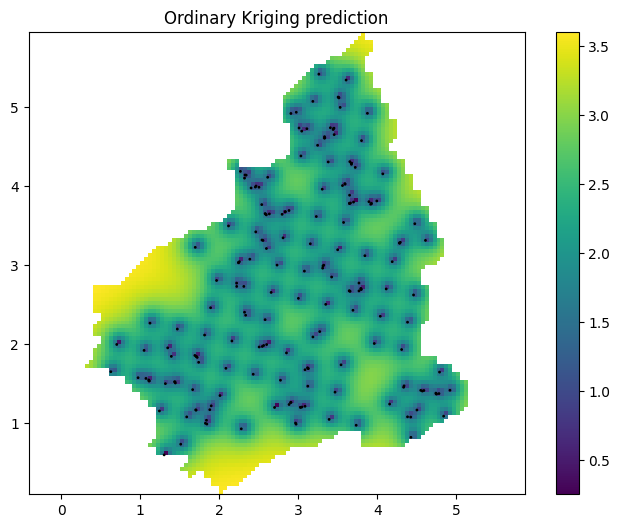

No variable name corresponding to your criterion


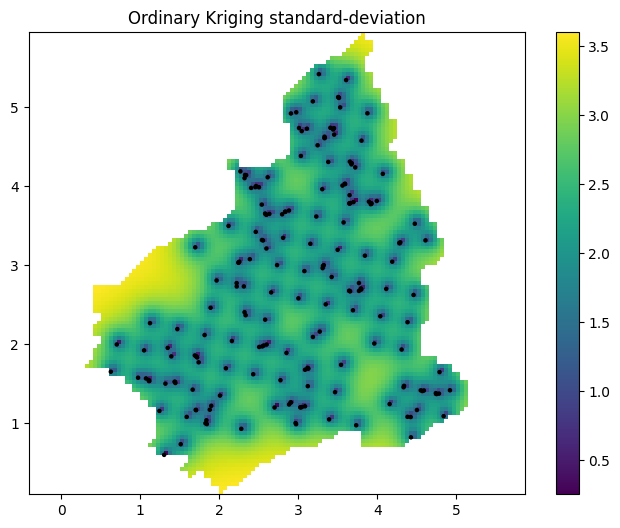

In [24]:
## Plot prediction
im = gp.plot(db_grid, "OK.Co.estim")
gp.plot(db_jura, c="black", s=1)
plt.title("Ordinary Kriging prediction")
plt.axis("equal")
plt.colorbar(im)
plt.show()

## Plot kriging standard-deviation
im = gp.plot(db_grid, "OK.Co.stdev")
gp.plot(db_jura, c="black", s=5)
plt.title("Ordinary Kriging standard-deviation")
plt.axis("equal")
plt.colorbar(im)
plt.show()

In [25]:
## Compute RMSE
rmse_OK = np.mean((val["Co"] - db_val["OK*estim"]) ** 2) ** 0.5
print("RMSE=", rmse_OK)

## Compute MAPE
mape_OK = np.mean(abs((val["Co"] - db_val["OK*estim"]) / val["Co"]))
print("MAPE=", mape_OK)

RMSE= 2.344630994718573
MAPE= 0.23516024058360024


### 3 - Moving neighborhoods

To perform moving neighborhood kriging, we specify any (or all) of the arguments `nmini` (min number of points to include), `nmaxi` (min number of points to include), `radius` (search radius of neighbors). If none of these arguments is specified, traditional kriging is performed. 

For instance, to perform kriging with a small Moving Neighborhood with only 1 sample per neighborhood (irregardless of its distance to the target point), we use the following command:


In [26]:
## Compute kriging
mg.minikriging(
    dbin=db_jura,
    dbout=db_grid,
    vname="Co",
    model=fitmod,
    nmini=1,
    nmaxi=1,
    prefix="Small",
)

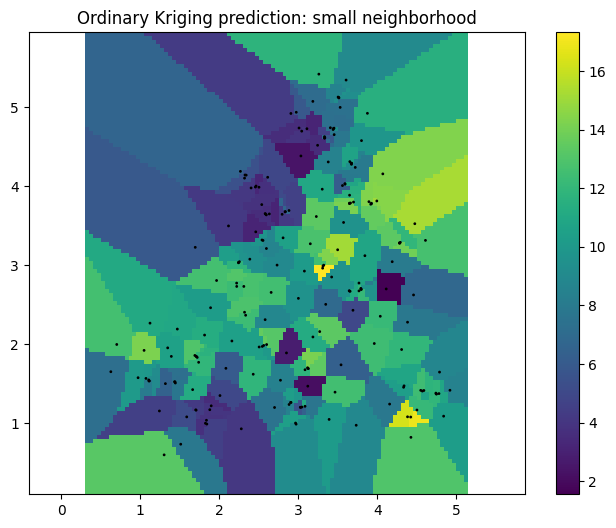

In [27]:
## Plot prediction
im = gp.plot(db_grid, "Small.Co.estim")
gp.plot(db_jura, c="black", s=1)
plt.title("Ordinary Kriging prediction: small neighborhood")
plt.axis("equal")
plt.colorbar(im)
plt.show()



**Create a moving neighborhood with radius 2 and containing between 1 and 20 points, and use it to perform an ordinary kriging prediction of Cobalt concentrations on the target grid. (Hint: Use the prefix "Large" to store the kriging results)**


In [28]:
## Compute kriging
mg.minikriging(
    dbin=db_jura,
    dbout=db_grid,
    vname="Co",
    model=fitmod,
    nmini=1,
    nmaxi=20,
    radius=2,
    prefix="Large",
)

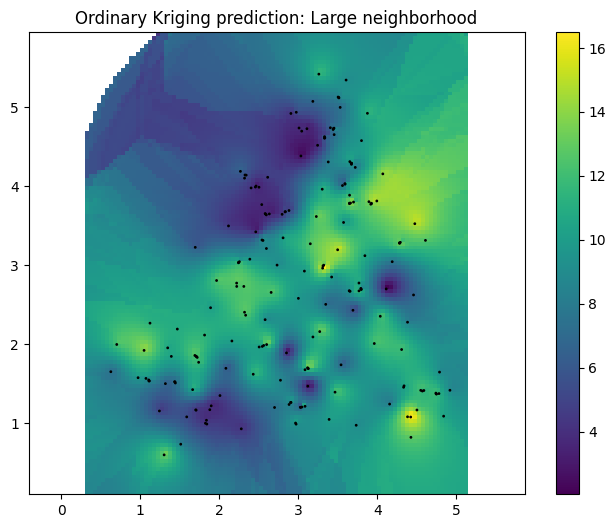

In [29]:
## Plot prediction
im = gp.plot(db_grid, "Large.Co.estim")
gp.plot(db_jura, c="black", s=1)
plt.title("Ordinary Kriging prediction: Large neighborhood")
plt.axis("equal")
plt.colorbar(im)
plt.show()

**Compute the ordinary kriging predictions at the validation locations using the same moving neighborhood, and  compute the resulting RMSE and MAPE. (Hint: Use the prefix "MvNeigh" to store the kriging results)**

In [30]:
## Compute kriging
mg.minikriging(
    dbin=db_jura,
    dbout=db_val,
    vname="Co",
    model=fitmod,
    nmini=1,
    nmaxi=20,
    radius=2,
    prefix="MvNeigh",
)

In [31]:
## Compute RMSE
rmse_OK_MN = np.mean((val["Co"] - db_val["MvNeigh*estim"]) ** 2) ** 0.5
print("RMSE=", rmse_OK_MN)

## Compute MAPE
mape_OK_MN = np.mean(abs((val["Co"] - db_val["MvNeigh*estim"]) / val["Co"]))
print("MAPE=", mape_OK_MN)

RMSE= 2.410050096148475
MAPE= 0.2392034314123293


#### **Now it's your turn! Try out different neighborhoods, models, types of kriging and try to imporve the RMSE!**

# II - Multivariate Models and Cokriging using gstlearn

To create and work with multivariate models, we simply need to supply the `vname` argument in the variogram and kriging functions with a list of names (instead of a single name).

Let us illustrate our point with our running example. We would like now to consider a multivariate model for Cobalt (Co) and Lead (Pb) concentrations. 

## II.1 - Fitting a multivariate model

To create experimental (directional) variograms and cross-variograms, we use the same commands as in the univariate case but supply the `vname` arguments with the names of the (two) variables with which we want to work.

In [32]:
## Create experimental variogram parametrization: 1 direction, 40 lags of size 0.05
varioexp2var = mg.vario_exp(db_jura, vname=["Co", "Pb"], nlag=40, dlag=0.05, toldis=0.5)

We can then plot the experimental variograms and cross-variograms with a simple command: the plot in the i-th row and j-th column corresponds to the cross-variogram between the variables i-th and j-th variable specified in the `vname` argument above. In particular, the diagonal plots correspond to the variograms of each variable.

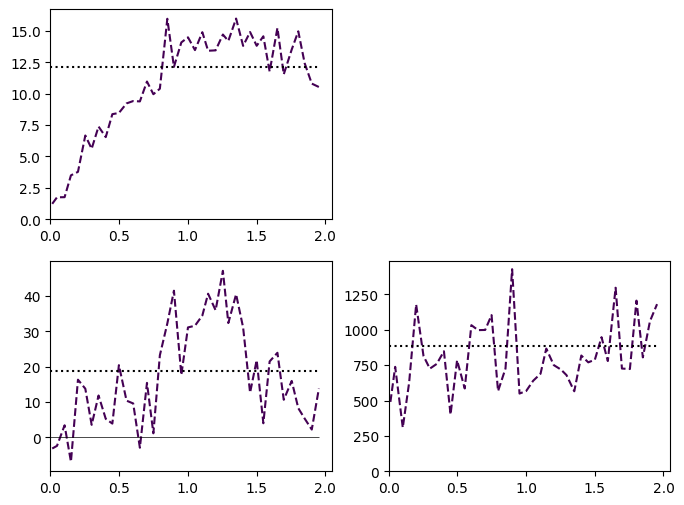

In [33]:
## Plot experimental variograms
ax = gp.varmod(varioexp2var)

To fit a model on the experimental variograms and cross-variograms, we use the same commands as in the univariate case. For instance, to fit a model containing two basic structures, a nugget effet (`"NUGGET"`) and a spherical covariance (`"SPHERICAL"`), we use the following command.

In [34]:
## Fit model on experimental cross-variograms
fitmod2var = mg.model_fit(
    varioexp2var, struct=["NUGGET", "SPHERICAL"], aniso_model=False
)

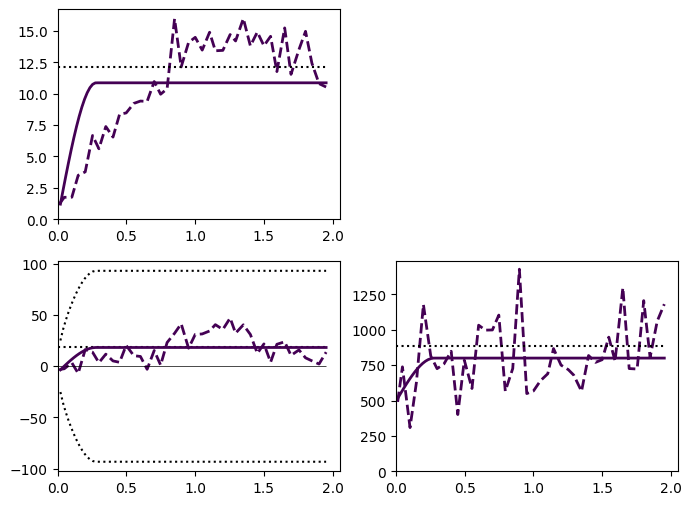

In [35]:
## Plot
ax = gp.varmod(varioexp2var, fitmod2var, lw=2)
# gp.decoration(ax,title="Co, Pb")

**Compute the experimental cross-variograms for the variables "Co", "Cu" and "Zn" and fit a model containing three basic structures a Nugget effet (`"NUGGET"`), an exponential covariance (`"EXPONENTIAL"`) and a cubic covariance (`"CUBIC"`).**

Warning, optimization return code is -1


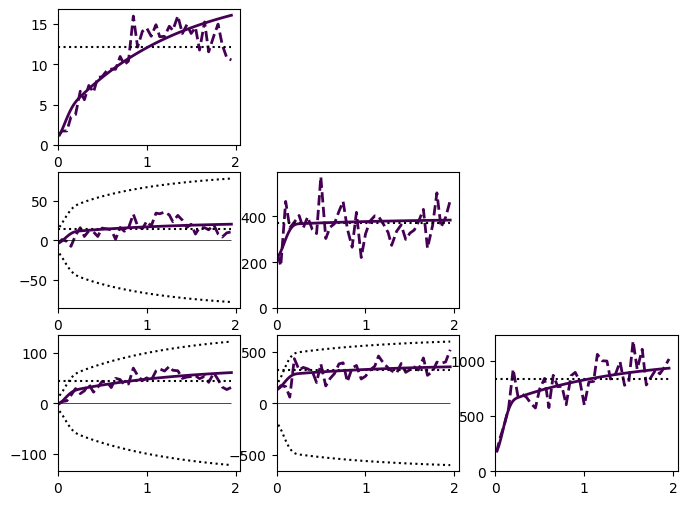

In [36]:
## Set locators
varioexp3var = mg.vario_exp(
    db_jura, vname=["Co", "Cu", "Zn"], nlag=40, dlag=0.05, toldis=0.5
)


fitmod3var = mg.model_fit(varioexp3var, struct=["NUGGET", "CUBIC", "EXPONENTIAL"])

## Plot
ax = gp.varmod(varioexp3var, fitmod3var, lw=2)

## II.2 - Cokriging predictions

To compute predictions by (ordinary) cokriging on the grid, we use the same syntax as in univariate case: a predictor for each variable in the multivariate model is produced. (Note: we revert back to a unique neighborhood to compare with the predictors previously introduced).

In [37]:
## Compute kriging (warning to the order of vname which has to be identical to one provided to the vario_exp function
mg.minikriging(
    dbin=db_jura,
    dbout=db_grid,
    vname=["Co", "Cu", "Zn"],
    model=fitmod3var,
    prefix="COK",
)

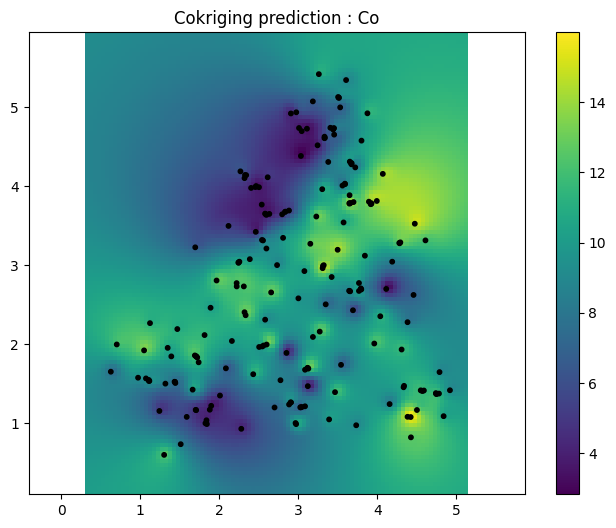

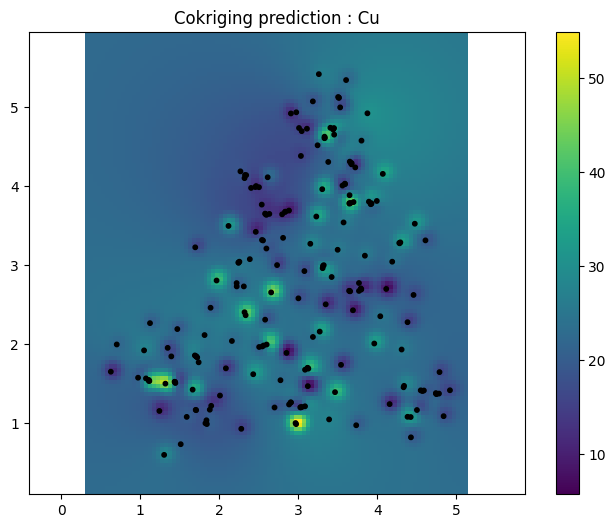

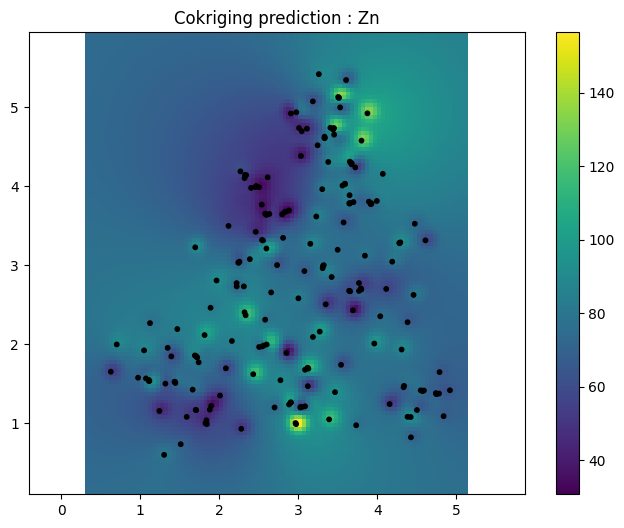

In [38]:
## Plot predictions
for metal_name in ["Co", "Cu", "Zn"]:
    im = gp.plot(db_grid, "COK." + metal_name + ".estim")
    gp.plot(db_jura, c="black", s=10)
    plt.colorbar(im)
    plt.axis("equal")
    plt.title("Cokriging prediction : " + metal_name)
    plt.show()

**Compute the ordinary co-kriging predictions at the validation locations using a unique neighborhood and compute the resulting RMSE and MAPE. (Hint: Use the prefix "COK" to store the results)**

In [39]:
## Compute kriging (warning to the order of vname which has to be identical to one provided to the vario_exp function
mg.minikriging(
    dbin=db_jura, dbout=db_val, vname=["Co", "Cu", "Zn"], model=fitmod3var, prefix="COK"
)

## Compute RMSE
rmse_COK = np.mean((val["Co"] - db_val["COK.Co.estim"]) ** 2) ** 0.5
print("RMSE=", rmse_COK)

## Compute MAPE
mape_COK = np.mean(abs((val["Co"] - db_val["COK.Co.estim"]) / val["Co"]))
print("MAPE=", mape_COK)

RMSE= 2.393015353726493
MAPE= 0.23137852308867193


#### **Now it's your turn! Try out different combinations of variables, neighborhoods, models, types of kriging and try to imporve the RMSE!**